In [1]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

C:\Users\Acer\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
words=[]
fname = "model.mm"

# load data
filename = 'dataset.txt'  #normal data: harry potter, anomaly data:cats
file = open(filename, 'rt',encoding="utf8" )
text = file.read()
file.close()

# split into words
tokens = word_tokenize(text)

# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation from each word

table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words[:100])


['harry', 'potter', 'chamber', 'secrets', 'j', 'k', 'rowling', 'book', 'harry', 'potter', 'series', 'original', 'scannedocr', 'friday', 'april', 'edit', 'needed', 'change', 'version', 'number', 'c', 'h', 'p', 'e', 'n', 'e', 'worst', 'birthday', 'first', 'time', 'argument', 'broken', 'breakfast', 'number', 'four', 'privet', 'drive', 'mr', 'vernon', 'dursley', 'woken', 'early', 'hours', 'morning', 'loud', 'hooting', 'noise', 'nephew', 'harry', 'room', 'third', 'time', 'week', 'roared', 'across', 'table', 'cant', 'control', 'owl', 'go', 'harry', 'tried', 'yet', 'explain', 'bored', 'said', 'used', 'flying', 'around', 'outside', 'could', 'let', 'night', 'look', 'stupid', 'snarled', 'uncle', 'vernon', 'bit', 'fried', 'egg', 'dangling', 'bushy', 'mustache', 'know', 'happen', 'owl', 'let', 'exchanged', 'dark', 'looks', 'wife', 'petunia', 'harry', 'tried', 'argue', 'back', 'words', 'drowned', 'long']


In [3]:
#Initialize model
model = Word2Vec([words])

#Save the model
model.save(fname)

In [4]:
model = Word2Vec.load("model.mm")
# Find words similar to food
vectors=model.wv
print("Close word to 'potter':",vectors.most_similar(['read'], topn=1))

Close word to 'potter': [('back', 0.9872410893440247)]


C:\Users\Acer\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Visualize the	vectors	using TSNE	technique, show anomalies and the string of words.

Visualize the	vectors	using	TSNE	technique	(https://lvdmaaten.github.io/tsne/) and	 show	anomalies. Show	the	string	of	words	on	the	TSNE	visualization.

In [5]:
import gensim
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [6]:
x = []
y = []
labels = []
tokens = []
def tsne_plot(model):
    "Creates and TSNE model and plots it"

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    plt.savefig('tsne_image.png')

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


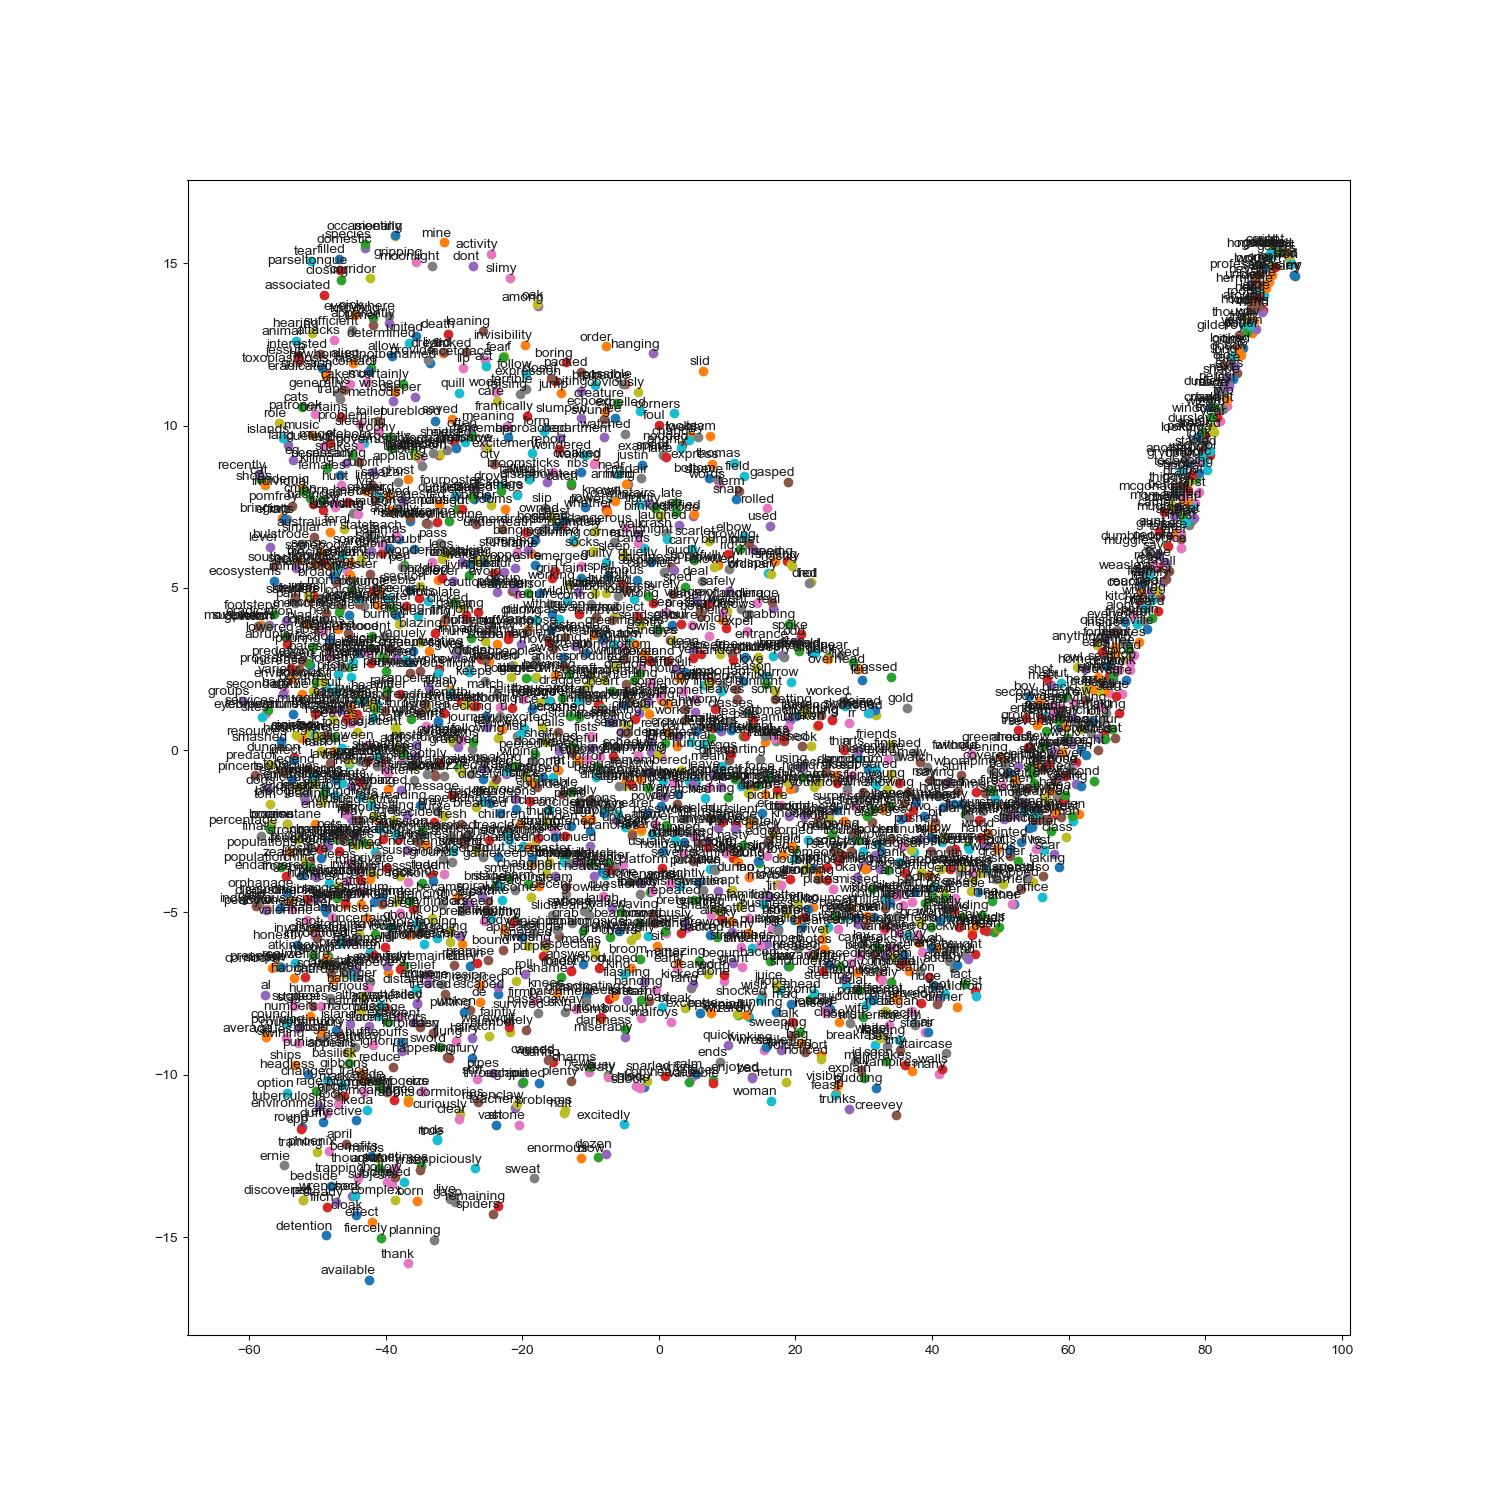

In [7]:
tsne_plot(model)

# Anomaly Detection

## Point Anomaly Detection: Isolation Forest 

In [8]:
X=np.asarray(x)
Y=np.asarray(y)
labels=np.asarray(labels)

C:\Users\Acer\Anaconda3\lib\site-packages\iso_forest.py:11: UserWarning: No igraph interface for plotting trees
  warnings.warn("No igraph interface for plotting trees")


<IPython.core.display.Javascript object>


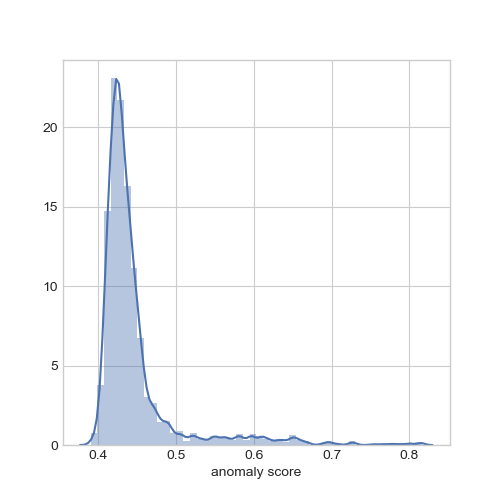

C:\Users\Acer\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [9]:
import iso_forest as iso
import seaborn as sb

sb.set_style(style="whitegrid")
sb.set_color_codes()


F = iso.iForest(np.asarray(tokens), ntrees=100, sample_size=256)
S=F.compute_paths(np.asarray(tokens))
f, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
sb.distplot(S, kde=True, color="b", ax=axes, axlabel='anomaly score')

<IPython.core.display.Javascript object>


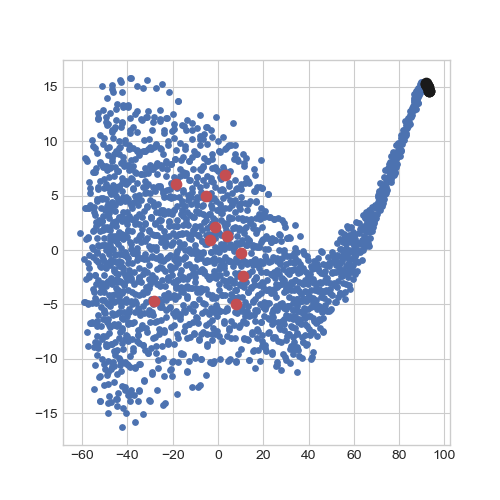

In [10]:
ss=np.argsort(S)
plt.figure(figsize=(5,5))
plt.scatter(X,Y,s=15,c='b',edgecolor='b')
plt.scatter(X[ss[-10:]],Y[ss[-10:]],s=55,c='k')
plt.scatter(X[ss[:10]],Y[ss[:10]],s=55,c='r')

## Group Anomaly Detection: 

In [16]:
from sklearn import svm

oneclass = svm.OneClassSVM(kernel='linear', gamma=0.001, nu=0.95)
oneclass.fit(np.asarray(tokens))
frauds = oneclass.predict(np.asarray(tokens))

<IPython.core.display.Javascript object>


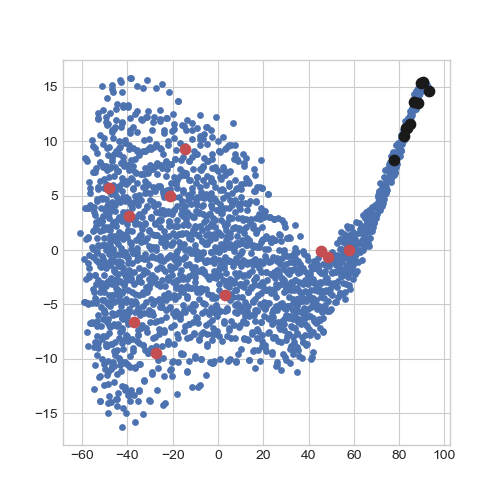

In [17]:
f=np.argsort(frauds)
plt.figure(figsize=(5,5))
plt.scatter(X,Y,s=15,c='b',edgecolor='b')
plt.scatter(X[f[-10:]],Y[f[-10:]],s=55,c='k')
plt.scatter(X[f[:10]],Y[f[:10]],s=55,c='r')